## Import the reference

In [14]:
import numpy as np

path_to_reference_file = \
    'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
    
with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)
    xi_ref = np.load(f)
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
x0 = [ q_ref[0], xi_ref[0] ]

## Embedded Euclidean Space Method


In [1]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation

# --------------------
# 1. 读取参考轨迹数据
# --------------------
path_to_reference_file = 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)   # 这里假设 q_ref[k] 对应 R_ref,k （某种形式储存）
    xi_ref = np.load(f)  # 这里假设 xi_ref[k] 对应 w_ref,k
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
# 初始状态 (姿态 + 角速度)
x0 = [q_ref[0], xi_ref[0]]  # 这里仅作演示，具体要看q_ref如何表示旋转


# --------------------
# 2. 定义指数映射和对数映射
# --------------------
def exp_so3(omega, h):
    """
    SO(3) 上的指数映射，使用 Rodrigues 公式进行离散化:
      R_{k+1} = R_k * exp( ω^∧ * h )
    这里 omega 为 R^3, h 为时间步长
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    I3 = ca.DM.eye(3)
    skew_omega = ca.skew(omega)  # <-- 直接使用 casadi 内置 skew
    
    # 为了避免 theta=0 时数值不稳定，可以做一个 if_else 处理：
    sin_theta_over_theta = ca.if_else(
        theta < 1e-9,
        1 - theta**2/6.0,         # sin(t)/t ~ 1 - t^2/6 + ...
        ca.sin(theta)/theta
    )
    one_minus_cos_over_theta2 = ca.if_else(
        theta < 1e-9,
        0.5 - theta**2/24.0,      # (1-cos(t))/t^2 ~ 0.5 - t^2/24 + ...
        (1 - ca.cos(theta))/theta**2
    )
    
    # Rodrigues 公式: exp(a^∧) = I + sin(|a|)/|a| * a^∧ + (1-cos(|a|))/|a|^2 * (a^∧)^2
    A = I3 \
        + sin_theta_over_theta*skew_omega*h \
        + one_minus_cos_over_theta2*(skew_omega @ skew_omega)*(h*h)
    return A

def log_so3(R):
    """
    SO(3) 的对数映射 (用于计算姿态误差).
    """
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    # 裁剪 cos_theta 避免数值超限
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]^T / 2
    skew_part = ca.vertcat(
        (R[2,1] - R[1,2]),
        (R[0,2] - R[2,0]),
        (R[1,0] - R[0,1])
    )
    sin_theta = ca.sin(theta)
    
    # 如果 sin(theta)=0，则返回0向量（避免除0）
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化到零向量
        # theta/(2*sin_theta)
        theta/(2*sin_theta)
    )
    
    return factor * skew_part

# --------------------
# 3. 搭建 Opti 问题
# --------------------
opti = ca.Opti()

# 参数定义：模型参数 (例如转动惯量矩阵 J, 权重矩阵 Q, R等)
J = np.diag([0.5, 0.7, 0.9])            # 简单示例，假设球对称
J_inv = np.linalg.inv(J)

Qx = np.diag([10., 10., 10.])           # 姿态误差的权重
Qw = np.diag([1.,  1.,  1.])           # 角速度误差的权重
QxN = 10 * Qx
QwN = 10 * Qw
R_ = np.identity(3) * 1e-5          # 控制输入惩罚

# 用于累计代价
cost = 0

# --------------------
# 4. 定义优化变量
# --------------------
R_vars = []
w_vars = []
u_vars = []

for k in range(Nsim+1):
    # R_k: 3x3 矩阵，有 9 个独立优化变量
    Rk = opti.variable(3,3)
    R_vars.append(Rk)
    # w_k: R^3
    wk = opti.variable(3,1)
    w_vars.append(wk)
    
    # 只在 k < Nsim 时定义控制变量 u_k
    if k < Nsim:
        uk = opti.variable(3,1)
        u_vars.append(uk)

# 设置初值 (从参考轨迹或者其他猜测中获取)
for k in range(Nsim+1):
    # 这里假设 q_ref[k] 是以 3x3 矩阵形式存储（如果不是，需要自己reshape）
    opti.set_initial(R_vars[k], q_ref[k])  
    opti.set_initial(w_vars[k], xi_ref[k])

for k in range(Nsim):
    opti.set_initial(u_vars[k], 0)

# --------------------
# 5. 动力学约束 + 正交约束 + 初始约束
# --------------------
for k in range(Nsim):
    Rk     = R_vars[k]
    Rk_next= R_vars[k+1]
    wk     = w_vars[k]
    wk_next= w_vars[k+1]
    uk     = u_vars[k]
    
    # (1) R_{k+1} = R_k * exp(w_k^∧ * h)
    Rk_prop = ca.mtimes(Rk, exp_so3(wk, dt))
    opti.subject_to(Rk_next - Rk_prop == 0)

    # (2) w_{k+1} = w_k + dt * J^{-1}[J w_k x w_k + u_k]
    cross_term = ca.cross(J @ wk, wk)  # J*w_k 与 w_k 的叉乘
    wk_prop = wk + dt * (J_inv @ (cross_term + uk))
    opti.subject_to(wk_next - wk_prop == 0)
    
    # (3) 正交约束 R_k^T * R_k = I
    # opti.subject_to(ca.mtimes(Rk.T, Rk) - ca.DM.eye(3) == 0)

# (4) 初始条件: 令 (R_0, w_0) = (q_ref[0], xi_ref[0])
q0 = ca.DM( Rotation.from_euler("zy",[45.,45.], degrees=True).as_matrix() )
xi0 = ca.DM( np.array([0.1,0.1,0.1]) )
opti.subject_to(R_vars[0] - q0 == 0)
opti.subject_to(w_vars[0] - xi0 == 0)

# 对终端 R_N 也加正交约束 (可选)
# opti.subject_to(ca.mtimes(R_vars[Nsim].T, R_vars[Nsim]) - ca.DM.eye(3) == 0)

# --------------------
# 6. 构建目标函数
# --------------------
for k in range(Nsim):
    Rk = R_vars[k]
    wk = w_vars[k]
    uk = u_vars[k]
    
    # 参考值
    Rref = q_ref[k]
    wref = xi_ref[k]
    Rref_dm = ca.DM(Rref)
    wref_dm = ca.DM(wref)

    # 姿态误差项：Log( R_k R_ref,k^{-1} )
    R_err = ca.mtimes(Rk, Rref_dm.T)  # 因为对正交矩阵 R_ref, R_ref^{-1} = R_ref^T
    log_Rerr = log_so3(R_err)
    cost_att = log_Rerr.T @ Qx @ log_Rerr
    
    # 角速度误差项
    w_diff = wk - wref_dm
    cost_w = w_diff.T @ Qw @ w_diff
    
    # 控制惩罚
    cost_u = uk.T @ R_ @ uk
    
    cost = cost + cost_att + cost_w + cost_u

# 终端项 l_N
R_N = R_vars[Nsim]
w_N = w_vars[Nsim]
RrefN = q_ref[Nsim]
wrefN = xi_ref[Nsim]
RrefN_dm = ca.DM(RrefN)
wrefN_dm = ca.DM(wrefN)

R_errN = ca.mtimes(R_N, RrefN_dm.T)
log_RerrN = log_so3(R_errN)
cost_attN = log_RerrN.T @ QxN @ log_RerrN

w_diffN = w_N - wrefN_dm
cost_wN = w_diffN.T @ QwN @ w_diffN

cost_terminal = cost_attN + cost_wN
cost = cost + cost_terminal

# 设置目标函数
opti.minimize(cost)

# --------------------
# 7. 求解
# --------------------
p_opts = {"verbose": False}
s_opts = {"max_iter": 2000}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)
    sol = None

# --------------------
# 8. 取回解并解析
# --------------------
if sol is not None:
    R_sol = []
    w_sol = []
    u_sol = []
    for k in range(Nsim+1):
        R_sol_k = sol.value(R_vars[k])
        w_sol_k = sol.value(w_vars[k])
        R_sol.append(R_sol_k)
        w_sol.append(w_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)
    
    print("Optimal cost:", sol.value(cost))
    # R_sol[k], w_sol[k], u_sol[k] 分别即为 k 时刻的最优解



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    20928
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20967

Total number of variables............................:     3747
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3000
Total number of inequality c

horizon is  250


Text(0, 0.5, 'Norm Value')

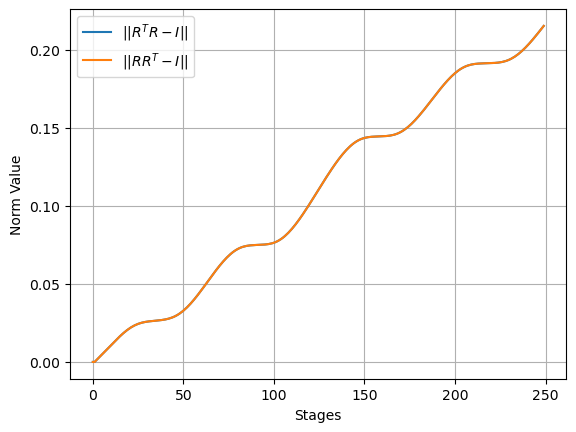

In [2]:
from scipy.linalg import norm
import matplotlib.pyplot as plt

print("horizon is ",len(R_sol))
list_RTR = [ R.T @ R - np.identity(3) for R in R_sol]
list_RRT = [ R @ R.T - np.identity(3) for R in R_sol]
list_RTR_norm = [ norm(R.T @ R - np.identity(3)) for R in R_sol]
list_RRT_norm = [ norm(R @ R.T - np.identity(3)) for R in R_sol]

plt.plot(list_RTR_norm, label=r"$||R^T R - I||$")
plt.plot(list_RRT_norm, label=r"$||R R^T - I||$")
plt.grid()
plt.legend()
plt.xlabel('Stages')
plt.ylabel('Norm Value')



In [20]:
list_RTR[3]

array([[-4.80408864e-04,  5.30920138e-05, -1.78054063e-04],
       [ 5.30920138e-05, -5.14518611e-04, -1.29782052e-04],
       [-1.78054063e-04, -1.29782052e-04, -1.11560263e-04]])

In [2]:
list_RRT[3]

NameError: name 'list_RRT' is not defined

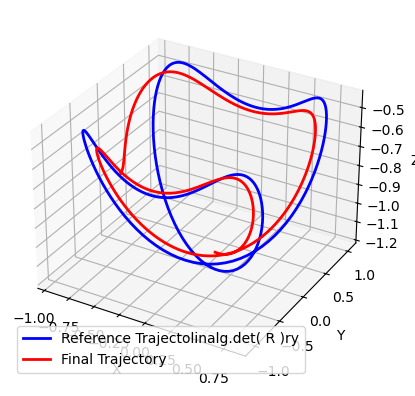

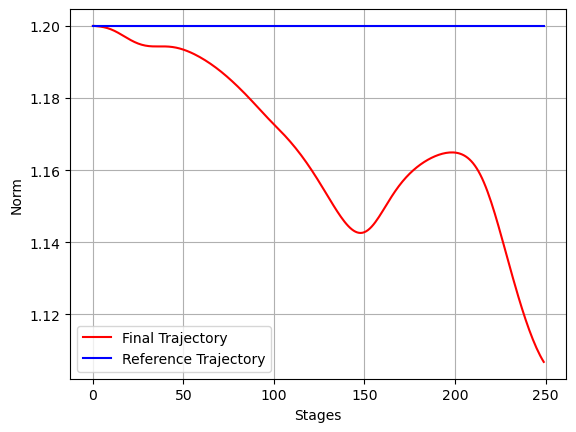

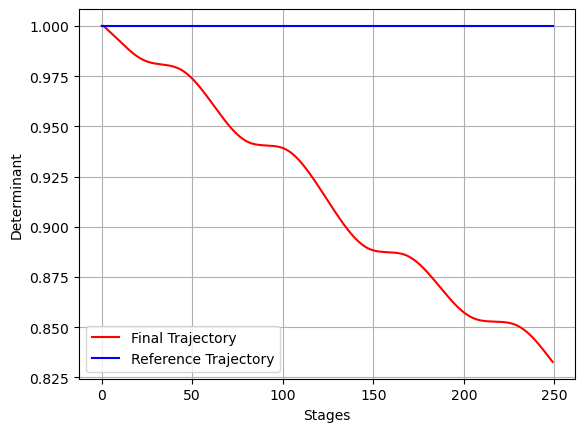

In [3]:
pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

rod_pos_sol = np.array([rotm @ updown_vector for rotm in R_sol]).reshape(Nsim+1, 3)
rod_pos_ref = np.array([rotm @ updown_vector for rotm in q_ref]).reshape(Nsim+1, 3)

norm_rod_pos_sol = np.array([norm(p) for p in rod_pos_sol ])
norm_rod_pos_ref = np.array([norm(p) for p in rod_pos_ref ])

det_sol = np.array([ np.linalg.det( rotm ) for rotm in R_sol])
det_ref = np.array([ np.linalg.det( rotm ) for rotm in q_ref])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(rod_pos_ref[:, 0], rod_pos_ref[:, 1], rod_pos_ref[:, 2],
            label='Reference Trajectolinalg.det( R )ry', color='blue', linewidth=2)
ax1.plot(rod_pos_sol[:, 0], rod_pos_sol[:, 1], rod_pos_sol[:, 2],
            label='Final Trajectory', color='red', linewidth=2)
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

fig2 = plt.figure()
plt.plot( norm_rod_pos_sol, label='Final Trajectory', color='red' )
plt.plot( norm_rod_pos_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Norm')
plt.legend()
plt.grid()

fig3 = plt.figure()
plt.plot( det_sol, label='Final Trajectory', color='red' )
plt.plot( det_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Determinant')
plt.legend()
plt.grid()






Try implementation without my expm but with casadi expm instead (but failed)

In [ ]:
import casadi as ca
import numpy as np

# --------------------
# 1. 读取参考轨迹数据
# --------------------
path_to_reference_file = 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)   # 这里假设 q_ref[k] 对应 R_ref,k （某种形式储存）
    xi_ref = np.load(f)  # 这里假设 xi_ref[k] 对应 w_ref,k
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
# 初始状态 (姿态 + 角速度)
x0 = [q_ref[0], xi_ref[0]]  # 这里仅作演示，具体要看q_ref如何表示旋转

# --------------------
# 2. (可选)查看casadi.skew的简单用法
# --------------------
# 假设 omega = [ωx, ωy, ωz]^T，则
#   casadi.skew(omega) = [[0, -ωz,  ωy],
#                         [ωz,  0, -ωx],
#                         [-ωy, ωx, 0 ]]


# --------------------
# 3. 定义指数映射和对数映射
# --------------------
def exp_so3(omega, h):
    """
    直接用 casadi.expm 来进行矩阵指数计算:
      R_{k+1} = R_k * exp( [omega]^∧ * h )
    """
    return ca.expm(ca.skew(omega) * h)

def log_so3(R):
    """
    SO(3) 的对数映射 (用于计算姿态误差).
    """
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    # 裁剪 cos_theta 避免数值超限
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]^T / 2
    skew_part = ca.vertcat(
        (R[2,1] - R[1,2]),
        (R[0,2] - R[2,0]),
        (R[1,0] - R[0,1])
    ) * 0.5
    sin_theta = ca.sin(theta)
    
    # 如果 sin(theta)=0，则返回0向量（避免除0）
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        1.0,  # 退化到零向量
        theta/(2*sin_theta)
    )
    
    return factor * skew_part

# --------------------
# 4. 搭建 Opti 问题
# --------------------
opti = ca.Opti()

# 参数定义：模型参数 (例如转动惯量矩阵 J, 权重矩阵 Q, R等)
J = np.diag([1.0, 1.0, 1.0])            # 简单示例，假设球对称
J_inv = np.linalg.inv(J)

Qx = np.diag([10., 10., 10.])           # 姿态误差的权重
Qw = np.diag([1.,  1.,  1.])           # 角速度误差的权重
R_ = np.diag([0.1, 0.1, 0.1])          # 控制输入惩罚

# 用于累计代价
cost = 0

# --------------------
# 5. 定义优化变量
# --------------------
R_vars = []
w_vars = []
u_vars = []

for k in range(Nsim+1):
    # R_k: 3x3 矩阵，有 9 个独立优化变量
    Rk = opti.variable(3,3)
    R_vars.append(Rk)
    # w_k: R^3
    wk = opti.variable(3,1)
    w_vars.append(wk)
    
    # 只在 k < Nsim 时定义控制变量 u_k
    if k < Nsim:
        uk = opti.variable(3,1)
        u_vars.append(uk)

# 设置初值 (从参考轨迹或者其他猜测中获取)
for k in range(Nsim+1):
    # 这里假设 q_ref[k] 是以 3x3 矩阵形式存储（如果不是，需要自己reshape）
    opti.set_initial(R_vars[k], q_ref[k])  
    opti.set_initial(w_vars[k], xi_ref[k])

for k in range(Nsim):
    opti.set_initial(u_vars[k], 0)

# --------------------
# 6. 动力学约束 + 正交约束 + 初始约束
# --------------------
for k in range(Nsim):
    Rk     = R_vars[k]
    Rk_next= R_vars[k+1]
    wk     = w_vars[k]
    wk_next= w_vars[k+1]
    uk     = u_vars[k]
    
    # (1) R_{k+1} = R_k * exp(w_k^∧ * h)
    Rk_prop = ca.mtimes(Rk, exp_so3(wk, dt))
    opti.subject_to(Rk_next - Rk_prop == 0)

    # (2) w_{k+1} = w_k + dt * J^{-1}[J w_k x w_k + u_k]
    cross_term = ca.cross(J @ wk, wk)  # J*w_k 与 w_k 的叉乘
    wk_prop = wk + dt * (J_inv @ (cross_term + uk))
    opti.subject_to(wk_next - wk_prop == 0)
    
    # (3) 正交约束 R_k^T * R_k = I
    # opti.subject_to(ca.mtimes(Rk.T, Rk) - ca.DM.eye(3) == 0)

# (4) 初始条件: 令 (R_0, w_0) = (q_ref[0], xi_ref[0])
opti.subject_to(R_vars[0] - q_ref[0] == 0)
opti.subject_to(w_vars[0] - xi_ref[0] == 0)

# 对终端 R_N 也加正交约束 (可选)
# opti.subject_to(ca.mtimes(R_vars[Nsim].T, R_vars[Nsim]) - ca.DM.eye(3) == 0)

# --------------------
# 7. 构建目标函数
# --------------------
for k in range(Nsim):
    Rk = R_vars[k]
    wk = w_vars[k]
    uk = u_vars[k]
    
    # 参考值
    Rref = q_ref[k]
    wref = xi_ref[k]
    Rref_dm = ca.DM(Rref)
    wref_dm = ca.DM(wref)

    # 姿态误差项：Log( R_k R_ref,k^{-1} )
    R_err = ca.mtimes(Rk, Rref_dm.T)  # 因为对正交矩阵 R_ref, R_ref^{-1} = R_ref^T
    log_Rerr = log_so3(R_err)
    cost_att = log_Rerr.T @ Qx @ log_Rerr
    
    # 角速度误差项
    w_diff = wk - wref_dm
    cost_w = w_diff.T @ Qw @ w_diff
    
    # 控制惩罚
    cost_u = uk.T @ R_ @ uk
    
    cost = cost + cost_att + cost_w + cost_u

# 终端项 l_N
R_N = R_vars[Nsim]
w_N = w_vars[Nsim]
RrefN = q_ref[Nsim]
wrefN = xi_ref[Nsim]
RrefN_dm = ca.DM(RrefN)
wrefN_dm = ca.DM(wrefN)

R_errN = ca.mtimes(R_N, RrefN_dm.T)
log_RerrN = log_so3(R_errN)
cost_attN = log_RerrN.T @ Qx @ log_RerrN

w_diffN = w_N - wrefN_dm
cost_wN = w_diffN.T @ Qw @ w_diffN

cost_terminal = cost_attN + cost_wN
cost = cost + cost_terminal

# 设置目标函数
opti.minimize(cost)

# --------------------
# 8. 求解
# --------------------
p_opts = {"verbose": False}
s_opts = {"max_iter": 2000}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)
    sol = None

# --------------------
# 9. 取回解并解析
# --------------------
if sol is not None:
    R_sol = []
    w_sol = []
    u_sol = []
    for k in range(Nsim+1):
        R_sol_k = sol.value(R_vars[k])
        w_sol_k = sol.value(w_vars[k])
        R_sol.append(R_sol_k)
        w_sol.append(w_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)
    
    print("Optimal cost:", sol.value(cost))
    # R_sol[k], w_sol[k], u_sol[k] 分别即为 k 时刻的最优解


## Constraint Stbailization Method

In [15]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation

# --------------------
# 1. 读取参考轨迹数据
# --------------------
path_to_reference_file = 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)   # 这里假设 q_ref[k] 对应 R_ref,k （某种形式储存）
    xi_ref = np.load(f)  # 这里假设 xi_ref[k] 对应 w_ref,k
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
# 初始状态 (姿态 + 角速度)
x0 = [q_ref[0], xi_ref[0]]  # 这里仅作演示，具体要看q_ref如何表示旋转


# --------------------
# 2. 定义指数映射和对数映射
# --------------------
def exp_so3(omega, h):
    """
    SO(3) 上的指数映射，使用 Rodrigues 公式进行离散化:
      R_{k+1} = R_k * exp( ω^∧ * h )
    这里 omega 为 R^3, h 为时间步长
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    I3 = ca.DM.eye(3)
    skew_omega = ca.skew(omega)  # <-- 直接使用 casadi 内置 skew
    
    # 为了避免 theta=0 时数值不稳定，可以做一个 if_else 处理：
    sin_theta_over_theta = ca.if_else(
        theta < 1e-9,
        1 - theta**2/6.0,         # sin(t)/t ~ 1 - t^2/6 + ...
        ca.sin(theta)/theta
    )
    one_minus_cos_over_theta2 = ca.if_else(
        theta < 1e-9,
        0.5 - theta**2/24.0,      # (1-cos(t))/t^2 ~ 0.5 - t^2/24 + ...
        (1 - ca.cos(theta))/theta**2
    )
    
    # Rodrigues 公式: exp(a^∧) = I + sin(|a|)/|a| * a^∧ + (1-cos(|a|))/|a|^2 * (a^∧)^2
    A = I3 \
        + sin_theta_over_theta*skew_omega*h \
        + one_minus_cos_over_theta2*(skew_omega @ skew_omega)*(h*h)
    return A

def log_so3(R):
    """
    SO(3) 的对数映射 (用于计算姿态误差).
    """
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    # 裁剪 cos_theta 避免数值超限
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]^T / 2
    skew_part = ca.vertcat(
        (R[2,1] - R[1,2]),
        (R[0,2] - R[2,0]),
        (R[1,0] - R[0,1])
    )
    sin_theta = ca.sin(theta)
    
    # 如果 sin(theta)=0，则返回0向量（避免除0）
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化到零向量
        # theta/(2*sin_theta)
        theta/(2*sin_theta)
    )
    
    return factor * skew_part

# --------------------
# 3. 搭建 Opti 问题
# --------------------
opti = ca.Opti()

# 参数定义：模型参数 (例如转动惯量矩阵 J, 权重矩阵 Q, R等)
J = np.diag([0.5, 0.7, 0.9])            # 简单示例，假设球对称
J_inv = np.linalg.inv(J)

Qx = np.diag([10., 10., 10.])           # 姿态误差的权重
Qw = np.diag([1.,  1.,  1.])           # 角速度误差的权重
QxN = 10 * Qx
QwN = 10 * Qw
R_ = np.identity(3) * 1e-5          # 控制输入惩罚

# 用于累计代价
cost = 0

# --------------------
# 4. 定义优化变量
# --------------------
R_vars = []
w_vars = []
u_vars = []

for k in range(Nsim+1):
    # R_k: 3x3 矩阵，有 9 个独立优化变量
    Rk = opti.variable(3,3)
    R_vars.append(Rk)
    # w_k: R^3
    wk = opti.variable(3,1)
    w_vars.append(wk)
    
    # 只在 k < Nsim 时定义控制变量 u_k
    if k < Nsim:
        uk = opti.variable(3,1)
        u_vars.append(uk)

# 设置初值 (从参考轨迹或者其他猜测中获取)
for k in range(Nsim+1):
    # 这里假设 q_ref[k] 是以 3x3 矩阵形式存储（如果不是，需要自己reshape）
    opti.set_initial(R_vars[k], q_ref[k])  
    opti.set_initial(w_vars[k], xi_ref[k])

for k in range(Nsim):
    opti.set_initial(u_vars[k], 0)

# --------------------
# 5. 动力学约束 + 正交约束 + 初始约束
# --------------------
for k in range(Nsim):
    Rk     = R_vars[k]
    Rk_next= R_vars[k+1]
    wk     = w_vars[k]
    wk_next= w_vars[k+1]
    uk     = u_vars[k]
    
    # (1) R_{k+1} = R_k * exp(w_k^∧ * h)
    kappa = 1e0
    Rk_prop = ca.mtimes(Rk, 
                        exp_so3(wk, dt) + kappa/2 * ( ca.inv(ca.mtimes(ca.transpose(Rk), Rk)) - ca.DM.eye(3)))
    opti.subject_to(Rk_next - Rk_prop == 0)

    # (2) w_{k+1} = w_k + dt * J^{-1}[J w_k x w_k + u_k]
    cross_term = ca.cross(J @ wk, wk)  # J*w_k 与 w_k 的叉乘
    wk_prop = wk + dt * (J_inv @ (cross_term + uk))
    opti.subject_to(wk_next - wk_prop == 0)
    
    # (3) 正交约束 R_k^T * R_k = I
    # opti.subject_to(ca.mtimes(Rk.T, Rk) - ca.DM.eye(3) == 0)

# (4) 初始条件: 令 (R_0, w_0) = (q_ref[0], xi_ref[0])
q0 = ca.DM( Rotation.from_euler("zy",[45.,45.], degrees=True).as_matrix() )
xi0 = ca.DM( np.array([0.1,0.1,0.1]) )
opti.subject_to(R_vars[0] - q0 == 0)
opti.subject_to(w_vars[0] - xi0 == 0)

# 对终端 R_N 也加正交约束 (可选)
# opti.subject_to(ca.mtimes(R_vars[Nsim].T, R_vars[Nsim]) - ca.DM.eye(3) == 0)

# --------------------
# 6. 构建目标函数
# --------------------
for k in range(Nsim):
    Rk = R_vars[k]
    wk = w_vars[k]
    uk = u_vars[k]
    
    # 参考值
    Rref = q_ref[k]
    wref = xi_ref[k]
    Rref_dm = ca.DM(Rref)
    wref_dm = ca.DM(wref)

    # 姿态误差项：Log( R_k R_ref,k^{-1} )
    R_err = ca.mtimes(Rk, Rref_dm.T)  # 因为对正交矩阵 R_ref, R_ref^{-1} = R_ref^T
    log_Rerr = log_so3(R_err)
    cost_att = log_Rerr.T @ Qx @ log_Rerr
    
    # 角速度误差项
    w_diff = wk - wref_dm
    cost_w = w_diff.T @ Qw @ w_diff
    
    # 控制惩罚
    cost_u = uk.T @ R_ @ uk
    
    cost = cost + cost_att + cost_w + cost_u

# 终端项 l_N
R_N = R_vars[Nsim]
w_N = w_vars[Nsim]
RrefN = q_ref[Nsim]
wrefN = xi_ref[Nsim]
RrefN_dm = ca.DM(RrefN)
wrefN_dm = ca.DM(wrefN)

R_errN = ca.mtimes(R_N, RrefN_dm.T)
log_RerrN = log_so3(R_errN)
cost_attN = log_RerrN.T @ QxN @ log_RerrN

w_diffN = w_N - wrefN_dm
cost_wN = w_diffN.T @ QwN @ w_diffN

cost_terminal = cost_attN + cost_wN
cost = cost + cost_terminal

# 设置目标函数
opti.minimize(cost)

# --------------------
# 7. 求解
# --------------------
p_opts = {"verbose": False}
s_opts = {"max_iter": 2000}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)
    sol = None

# --------------------
# 8. 取回解并解析
# --------------------
if sol is not None:
    R_sol = []
    w_sol = []
    u_sol = []
    for k in range(Nsim+1):
        R_sol_k = sol.value(R_vars[k])
        w_sol_k = sol.value(w_vars[k])
        R_sol.append(R_sol_k)
        w_sol.append(w_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)
    
    print("Optimal cost:", sol.value(cost))
    # R_sol[k], w_sol[k], u_sol[k] 分别即为 k 时刻的最优解


This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    68874
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    41967

Total number of variables............................:     7497
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.22e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

horizon is  500


Text(0, 0.5, 'Norm Value')

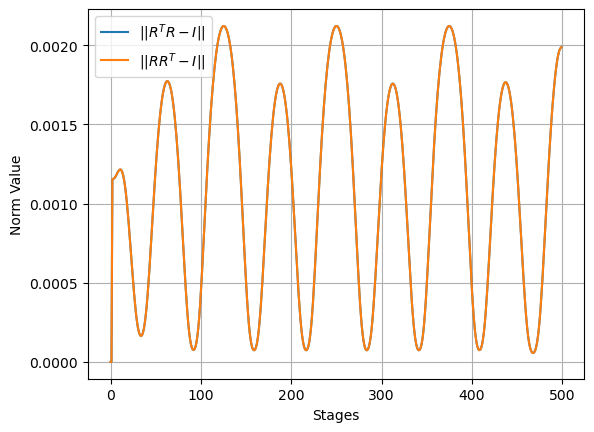

In [16]:
from scipy.linalg import norm
import matplotlib.pyplot as plt

print("horizon is ",len(R_sol))
list_RTR = [ R.T @ R - np.identity(3) for R in R_sol]
list_RRT = [ R @ R.T - np.identity(3) for R in R_sol]
list_RTR_norm = [ norm(R.T @ R - np.identity(3)) for R in R_sol]
list_RRT_norm = [ norm(R @ R.T - np.identity(3)) for R in R_sol]

plt.plot(list_RTR_norm, label=r"$||R^T R - I||$")
plt.plot(list_RRT_norm, label=r"$||R R^T - I||$")
plt.grid()
plt.legend()
plt.xlabel('Stages')
plt.ylabel('Norm Value')



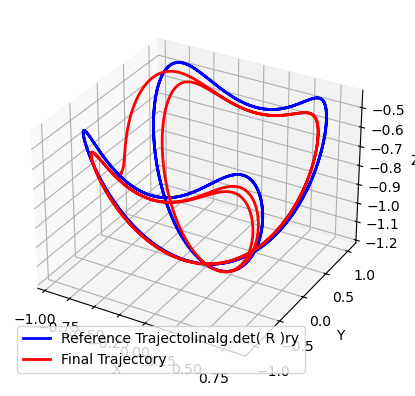

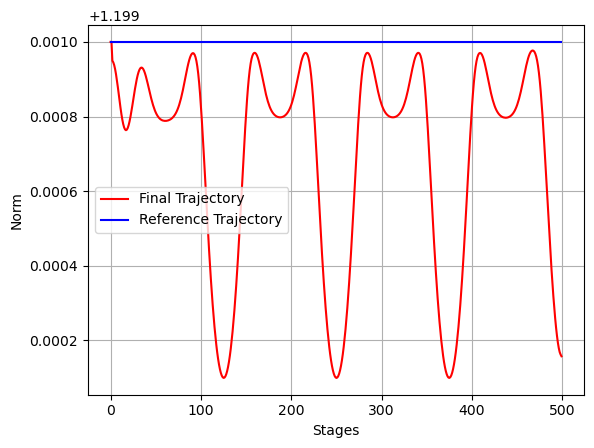

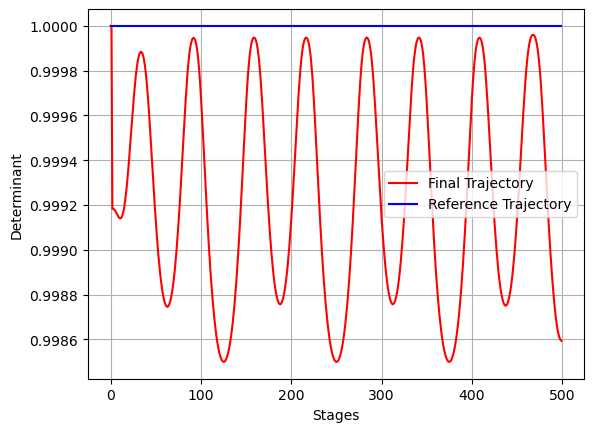

In [17]:
pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

rod_pos_sol = np.array([rotm @ updown_vector for rotm in R_sol]).reshape(Nsim+1, 3)
rod_pos_ref = np.array([rotm @ updown_vector for rotm in q_ref]).reshape(Nsim+1, 3)

norm_rod_pos_sol = np.array([norm(p) for p in rod_pos_sol ])
norm_rod_pos_ref = np.array([norm(p) for p in rod_pos_ref ])

det_sol = np.array([ np.linalg.det( rotm ) for rotm in R_sol])
det_ref = np.array([ np.linalg.det( rotm ) for rotm in q_ref])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(rod_pos_ref[:, 0], rod_pos_ref[:, 1], rod_pos_ref[:, 2],
            label='Reference Trajectolinalg.det( R )ry', color='blue', linewidth=2)
ax1.plot(rod_pos_sol[:, 0], rod_pos_sol[:, 1], rod_pos_sol[:, 2],
            label='Final Trajectory', color='red', linewidth=2)
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

fig2 = plt.figure()
plt.plot( norm_rod_pos_sol, label='Final Trajectory', color='red' )
plt.plot( norm_rod_pos_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Norm')
plt.legend()
plt.grid()

fig3 = plt.figure()
plt.plot( det_sol, label='Final Trajectory', color='red' )
plt.plot( det_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Determinant')
plt.legend()
plt.grid()






## Constraint Stabilization Method with Matrix Norm Cost Function

In [11]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation

# --------------------
# 1. 读取参考轨迹数据
# --------------------
path_to_reference_file = 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)   # 这里假设 q_ref[k] 对应 R_ref,k （某种形式储存）
    xi_ref = np.load(f)  # 这里假设 xi_ref[k] 对应 w_ref,k
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
# 初始状态 (姿态 + 角速度)
x0 = [q_ref[0], xi_ref[0]]  # 这里仅作演示，具体要看q_ref如何表示旋转


# --------------------
# 2. 定义指数映射和对数映射
# --------------------
def exp_so3(omega, h):
    """
    SO(3) 上的指数映射，使用 Rodrigues 公式进行离散化:
      R_{k+1} = R_k * exp( ω^∧ * h )
    这里 omega 为 R^3, h 为时间步长
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    I3 = ca.DM.eye(3)
    skew_omega = ca.skew(omega)  # <-- 直接使用 casadi 内置 skew
    
    # 为了避免 theta=0 时数值不稳定，可以做一个 if_else 处理：
    sin_theta_over_theta = ca.if_else(
        theta < 1e-9,
        1 - theta**2/6.0,         # sin(t)/t ~ 1 - t^2/6 + ...
        ca.sin(theta)/theta
    )
    one_minus_cos_over_theta2 = ca.if_else(
        theta < 1e-9,
        0.5 - theta**2/24.0,      # (1-cos(t))/t^2 ~ 0.5 - t^2/24 + ...
        (1 - ca.cos(theta))/theta**2
    )
    
    # Rodrigues 公式: exp(a^∧) = I + sin(|a|)/|a| * a^∧ + (1-cos(|a|))/|a|^2 * (a^∧)^2
    A = I3 \
        + sin_theta_over_theta*skew_omega*h \
        + one_minus_cos_over_theta2*(skew_omega @ skew_omega)*(h*h)
    return A

def log_so3(R):
    """
    SO(3) 的对数映射 (用于计算姿态误差).
    """
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    # 裁剪 cos_theta 避免数值超限
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]^T / 2
    skew_part = ca.vertcat(
        (R[2,1] - R[1,2]),
        (R[0,2] - R[2,0]),
        (R[1,0] - R[0,1])
    )
    sin_theta = ca.sin(theta)
    
    # 如果 sin(theta)=0，则返回0向量（避免除0）
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化到零向量
        # theta/(2*sin_theta)
        theta/(2*sin_theta)
    )
    
    return factor * skew_part

# --------------------
# 3. 搭建 Opti 问题
# --------------------
opti = ca.Opti()

# 参数定义：模型参数 (例如转动惯量矩阵 J, 权重矩阵 Q, R等)
J = np.diag([0.5, 0.7, 0.9])            # 简单示例，假设球对称
J_inv = np.linalg.inv(J)

Qx = np.diag([10., 10., 10.])           # 姿态误差的权重
Qw = np.diag([1.,  1.,  1.])           # 角速度误差的权重
QxN = 10 * Qx
QwN = 10 * Qw
R_ = np.identity(3) * 1e-5          # 控制输入惩罚

# 新增：姿态误差采用 Frobenius norm 的平方时，可以直接用一个标量 alpha 表示加权
alpha = 10.0       # 姿态误差的权重
alphaN = 10.0*alpha  # 末端姿态误差再大一些

# 用于累计代价
cost = 0

# --------------------
# 4. 定义优化变量
# --------------------
R_vars = []
w_vars = []
u_vars = []

for k in range(Nsim+1):
    # R_k: 3x3 矩阵，有 9 个独立优化变量
    Rk = opti.variable(3,3)
    R_vars.append(Rk)
    # w_k: R^3
    wk = opti.variable(3,1)
    w_vars.append(wk)
    
    # 只在 k < Nsim 时定义控制变量 u_k
    if k < Nsim:
        uk = opti.variable(3,1)
        u_vars.append(uk)

# 设置初值 (从参考轨迹或者其他猜测中获取)
for k in range(Nsim+1):
    # 这里假设 q_ref[k] 是以 3x3 矩阵形式存储（如果不是，需要自己reshape）
    opti.set_initial(R_vars[k], q_ref[k])  
    opti.set_initial(w_vars[k], xi_ref[k])

for k in range(Nsim):
    opti.set_initial(u_vars[k], 0)

# --------------------
# 5. 动力学约束 + 正交约束 + 初始约束
# --------------------
for k in range(Nsim):
    Rk     = R_vars[k]
    Rk_next= R_vars[k+1]
    wk     = w_vars[k]
    wk_next= w_vars[k+1]
    uk     = u_vars[k]
    
    # (1) R_{k+1} = R_k * exp(w_k^∧ * h)
    kappa = 1e0
    Rk_prop = ca.mtimes(Rk, 
                        exp_so3(wk, dt) + kappa/2 * ( ca.inv(ca.mtimes(ca.transpose(Rk), Rk)) - ca.DM.eye(3)))
    opti.subject_to(Rk_next - Rk_prop == 0)

    # (2) w_{k+1} = w_k + dt * J^{-1}[J w_k x w_k + u_k]
    cross_term = ca.cross(J @ wk, wk)  # J*w_k 与 w_k 的叉乘
    wk_prop = wk + dt * (J_inv @ (cross_term + uk))
    opti.subject_to(wk_next - wk_prop == 0)
    
    # (3) 正交约束 R_k^T * R_k = I
    # opti.subject_to(ca.mtimes(Rk.T, Rk) - ca.DM.eye(3) == 0)

# (4) 初始条件: 令 (R_0, w_0) = (q_ref[0], xi_ref[0])
q0 = ca.DM( Rotation.from_euler("zy",[45.,45.], degrees=True).as_matrix() )
xi0 = ca.DM( np.array([0.1,0.1,0.1]) )
opti.subject_to(R_vars[0] - q0 == 0)
opti.subject_to(w_vars[0] - xi0 == 0)

# 对终端 R_N 也加正交约束 (可选)
# opti.subject_to(ca.mtimes(R_vars[Nsim].T, R_vars[Nsim]) - ca.DM.eye(3) == 0)

# --------------------
# 6. 构建目标函数
# --------------------
for k in range(Nsim):
    Rk = R_vars[k]
    wk = w_vars[k]
    uk = u_vars[k]
    
    # 参考值
    Rref = q_ref[k]
    wref = xi_ref[k]
    Rref_dm = ca.DM(Rref)
    wref_dm = ca.DM(wref)

    # 姿态误差项：Log( R_k R_ref,k^{-1} )
    # R_err = ca.mtimes(Rk, Rref_dm.T)  # 因为对正交矩阵 R_ref, R_ref^{-1} = R_ref^T
    # log_Rerr = log_so3(R_err)
    # cost_att = log_Rerr.T @ Qx @ log_Rerr
    R_diff = Rk - Rref_dm
    cost_att = alpha * ca.sumsqr(R_diff)
    
    # 角速度误差项
    w_diff = wk - wref_dm
    cost_w = w_diff.T @ Qw @ w_diff
    
    # 控制惩罚
    cost_u = uk.T @ R_ @ uk
    
    cost = cost + cost_att + cost_w + cost_u

# 终端项 l_N
R_N = R_vars[Nsim]
w_N = w_vars[Nsim]
RrefN = q_ref[Nsim]
wrefN = xi_ref[Nsim]
RrefN_dm = ca.DM(RrefN)
wrefN_dm = ca.DM(wrefN)

# R_errN = ca.mtimes(R_N, RrefN_dm.T)
# log_RerrN = log_so3(R_errN)
# cost_attN = log_RerrN.T @ QxN @ log_RerrN
R_diff = Rk - Rref_dm
cost_attN = alphaN * ca.sumsqr(R_diff)

w_diffN = w_N - wrefN_dm
cost_wN = w_diffN.T @ QwN @ w_diffN

cost_terminal = cost_attN + cost_wN
cost = cost + cost_terminal

# 设置目标函数
opti.minimize(cost)

# --------------------
# 7. 求解
# --------------------
p_opts = {"verbose": False}
s_opts = {"max_iter": 2000}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)
    sol = None

# --------------------
# 8. 取回解并解析
# --------------------
if sol is not None:
    R_sol = []
    w_sol = []
    u_sol = []
    for k in range(Nsim+1):
        R_sol_k = sol.value(R_vars[k])
        w_sol_k = sol.value(w_vars[k])
        R_sol.append(R_sol_k)
        w_sol.append(w_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)
    
    print("Optimal cost:", sol.value(cost))
    # R_sol[k], w_sol[k], u_sol[k] 分别即为 k 时刻的最优解


This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    68874
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    41922

Total number of variables............................:     7497
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.22e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

horizon is  500


Text(0, 0.5, 'Norm Value')

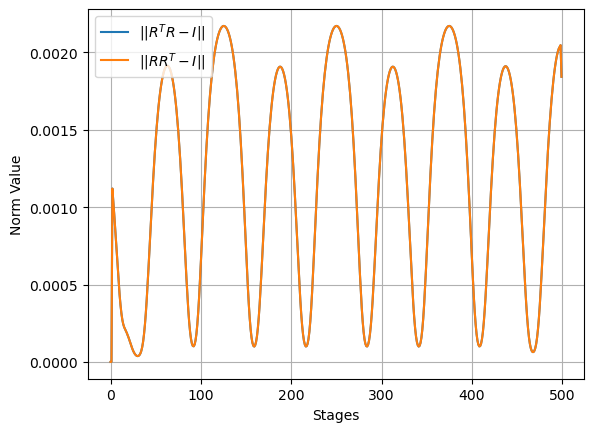

In [12]:
from scipy.linalg import norm
import matplotlib.pyplot as plt

print("horizon is ",len(R_sol))
list_RTR = [ R.T @ R - np.identity(3) for R in R_sol]
list_RRT = [ R @ R.T - np.identity(3) for R in R_sol]
list_RTR_norm = [ norm(R.T @ R - np.identity(3)) for R in R_sol]
list_RRT_norm = [ norm(R @ R.T - np.identity(3)) for R in R_sol]

plt.plot(list_RTR_norm, label=r"$||R^T R - I||$")
plt.plot(list_RRT_norm, label=r"$||R R^T - I||$")
plt.grid()
plt.legend()
plt.xlabel('Stages')
plt.ylabel('Norm Value')


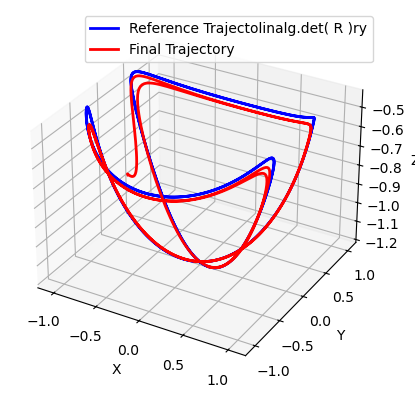

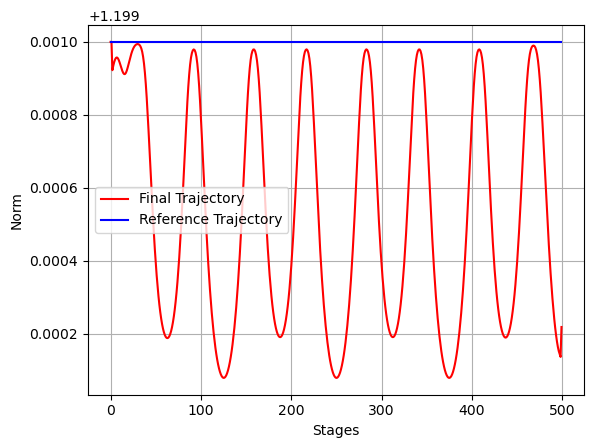

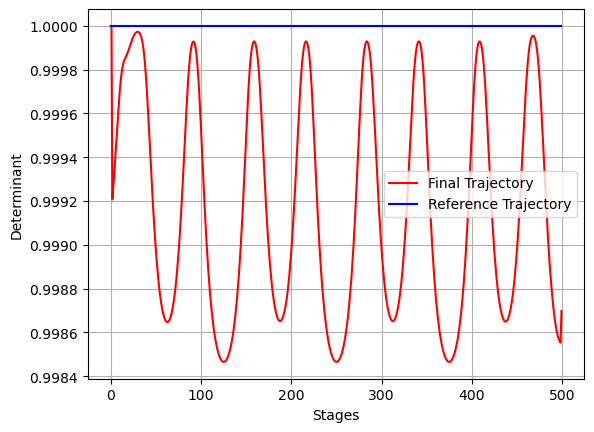

In [13]:
pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

rod_pos_sol = np.array([rotm @ updown_vector for rotm in R_sol]).reshape(Nsim+1, 3)
rod_pos_ref = np.array([rotm @ updown_vector for rotm in q_ref]).reshape(Nsim+1, 3)

norm_rod_pos_sol = np.array([norm(p) for p in rod_pos_sol ])
norm_rod_pos_ref = np.array([norm(p) for p in rod_pos_ref ])

det_sol = np.array([ np.linalg.det( rotm ) for rotm in R_sol])
det_ref = np.array([ np.linalg.det( rotm ) for rotm in q_ref])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(rod_pos_ref[:, 0], rod_pos_ref[:, 1], rod_pos_ref[:, 2],
            label='Reference Trajectolinalg.det( R )ry', color='blue', linewidth=2)
ax1.plot(rod_pos_sol[:, 0], rod_pos_sol[:, 1], rod_pos_sol[:, 2],
            label='Final Trajectory', color='red', linewidth=2)
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

fig2 = plt.figure()
plt.plot( norm_rod_pos_sol, label='Final Trajectory', color='red' )
plt.plot( norm_rod_pos_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Norm')
plt.legend()
plt.grid()

fig3 = plt.figure()
plt.plot( det_sol, label='Final Trajectory', color='red' )
plt.plot( det_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Determinant')
plt.legend()
plt.grid()






## Pendulum Baseline withOUT Constraint Stabilization

In [3]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation

# --------------------
# 1. 读取参考轨迹数据
# --------------------
path_to_reference_file = 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)   # 这里假设 q_ref[k] 对应 R_ref,k （某种形式储存）
    xi_ref = np.load(f)  # 这里假设 xi_ref[k] 对应 w_ref,k
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
# 初始状态 (姿态 + 角速度)
x0 = [q_ref[0], xi_ref[0]]  # 这里仅作演示，具体要看q_ref如何表示旋转


# --------------------
# 2. 定义指数映射和对数映射
# --------------------
def exp_so3(omega, h):
    """
    SO(3) 上的指数映射，使用 Rodrigues 公式进行离散化:
      R_{k+1} = R_k * exp( ω^∧ * h )
    这里 omega 为 R^3, h 为时间步长
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    I3 = ca.DM.eye(3)
    skew_omega = ca.skew(omega)  # <-- 直接使用 casadi 内置 skew
    
    # 为了避免 theta=0 时数值不稳定，可以做一个 if_else 处理：
    sin_theta_over_theta = ca.if_else(
        theta < 1e-9,
        1 - theta**2/6.0,         # sin(t)/t ~ 1 - t^2/6 + ...
        ca.sin(theta)/theta
    )
    one_minus_cos_over_theta2 = ca.if_else(
        theta < 1e-9,
        0.5 - theta**2/24.0,      # (1-cos(t))/t^2 ~ 0.5 - t^2/24 + ...
        (1 - ca.cos(theta))/theta**2
    )
    
    # Rodrigues 公式: exp(a^∧) = I + sin(|a|)/|a| * a^∧ + (1-cos(|a|))/|a|^2 * (a^∧)^2
    A = I3 \
        + sin_theta_over_theta*skew_omega*h \
        + one_minus_cos_over_theta2*(skew_omega @ skew_omega)*(h*h)
    return A

def log_so3(R):
    """
    SO(3) 的对数映射 (用于计算姿态误差).
    """
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    # 裁剪 cos_theta 避免数值超限
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]^T / 2
    skew_part = ca.vertcat(
        (R[2,1] - R[1,2]),
        (R[0,2] - R[2,0]),
        (R[1,0] - R[0,1])
    )
    sin_theta = ca.sin(theta)
    
    # 如果 sin(theta)=0，则返回0向量（避免除0）
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化到零向量
        # theta/(2*sin_theta)
        theta/(2*sin_theta)
    )
    
    return factor * skew_part

# --------------------
# 3. 搭建 Opti 问题
# --------------------
opti = ca.Opti()

# 参数定义：模型参数 (例如转动惯量矩阵 J, 权重矩阵 Q, R等)
J = np.diag([0.5, 0.7, 0.9])            # 简单示例，假设球对称
J_inv = np.linalg.inv(J)
m = 1
length = 0.5
g = 9.8

Qx = np.diag([10., 10., 10.])           # 姿态误差的权重
Qw = np.diag([1.,  1.,  1.])           # 角速度误差的权重
QxN = 10 * Qx
QwN = 10 * Qw
R_ = np.identity(3) * 1e-2          # 控制输入惩罚

# 用于累计代价
cost = 0

# --------------------
# 4. 定义优化变量
# --------------------
R_vars = []
w_vars = []
u_vars = []

for k in range(Nsim+1):
    # R_k: 3x3 矩阵，有 9 个独立优化变量
    Rk = opti.variable(3,3)
    R_vars.append(Rk)
    # w_k: R^3
    wk = opti.variable(3,1)
    w_vars.append(wk)
    
    # 只在 k < Nsim 时定义控制变量 u_k
    if k < Nsim:
        uk = opti.variable(3,1)
        u_vars.append(uk)

# 设置初值 (从参考轨迹或者其他猜测中获取)
for k in range(Nsim+1):
    # 这里假设 q_ref[k] 是以 3x3 矩阵形式存储（如果不是，需要自己reshape）
    opti.set_initial(R_vars[k], q_ref[k])  
    opti.set_initial(w_vars[k], xi_ref[k])

for k in range(Nsim):
    opti.set_initial(u_vars[k], 0)

# --------------------
# 5. 动力学约束 + 正交约束 + 初始约束
# --------------------
for k in range(Nsim):
    Rk     = R_vars[k]
    Rk_next= R_vars[k+1]
    wk     = w_vars[k]
    wk_next= w_vars[k+1]
    uk     = u_vars[k]
    
    # (1) R_{k+1} = R_k * exp(w_k^∧ * h)
    Rk_prop = ca.mtimes(Rk, 
                        exp_so3(wk, dt))
    opti.subject_to(Rk_next - Rk_prop == 0)

    # (2) w_{k+1} = w_k + dt * J^{-1}[J w_k x w_k + u_k]
    cross_term = ca.cross(J @ wk, wk)  # J*w_k 与 w_k 的叉乘
    
    down_vec = np.array([0., 0., -1.])
    rho = length / 2 * down_vec
    g_term = ca.cross( m*g*rho, ca.mtimes(ca.transpose(Rk), down_vec) )
    M = ca.cross( m*rho,  ca.mtimes(ca.transpose(Rk), uk) )

    wk_prop = wk + dt * (J_inv @ (cross_term + M))
    opti.subject_to(wk_next - wk_prop == 0)
    
    # (3) 正交约束 R_k^T * R_k = I
    # opti.subject_to(ca.mtimes(Rk.T, Rk) - ca.DM.eye(3) == 0)

# (4) 初始条件: 令 (R_0, w_0) = (q_ref[0], xi_ref[0])
q0 = ca.DM( Rotation.from_euler("y",50., degrees=True).as_matrix() )
xi0 = ca.DM( np.array([0.1,0.1,0.1]) )
opti.subject_to(R_vars[0] - q0 == 0)
opti.subject_to(w_vars[0] - xi0 == 0)
# opti.subject_to(R_vars[0] - ca.DM.eye(3) == 0)
# opti.subject_to(w_vars[0] == 0)


# 对终端 R_N 也加正交约束 (可选)
# opti.subject_to(ca.mtimes(R_vars[Nsim].T, R_vars[Nsim]) - ca.DM.eye(3) == 0)

# --------------------
# 6. 构建目标函数
# --------------------
for k in range(Nsim):
    Rk = R_vars[k]
    wk = w_vars[k]
    uk = u_vars[k]
    
    # 参考值
    Rref = q_ref[k]
    wref = xi_ref[k]
    Rref_dm = ca.DM(Rref)
    wref_dm = ca.DM(wref)

    # 姿态误差项：Log( R_k R_ref,k^{-1} )
    R_err = ca.mtimes(Rk, Rref_dm.T)  # 因为对正交矩阵 R_ref, R_ref^{-1} = R_ref^T
    log_Rerr = log_so3(R_err)
    cost_att = log_Rerr.T @ Qx @ log_Rerr
    
    # 角速度误差项
    w_diff = wk - wref_dm
    cost_w = w_diff.T @ Qw @ w_diff
    
    # 控制惩罚
    cost_u = uk.T @ R_ @ uk
    
    cost = cost + cost_att + cost_w + cost_u

# 终端项 l_N
R_N = R_vars[Nsim]
w_N = w_vars[Nsim]
RrefN = q_ref[Nsim]
wrefN = xi_ref[Nsim]
RrefN_dm = ca.DM(RrefN)
wrefN_dm = ca.DM(wrefN)

R_errN = ca.mtimes(R_N, RrefN_dm.T)
log_RerrN = log_so3(R_errN)
cost_attN = log_RerrN.T @ QxN @ log_RerrN

w_diffN = w_N - wrefN_dm
cost_wN = w_diffN.T @ QwN @ w_diffN

cost_terminal = cost_attN + cost_wN
cost = cost + cost_terminal

# 设置目标函数
opti.minimize(cost)

# --------------------
# 7. 求解
# --------------------
p_opts = {"verbose": False}
s_opts = {"max_iter": 2000}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)
    sol = None

# --------------------
# 8. 取回解并解析
# --------------------
if sol is not None:
    R_sol = []
    w_sol = []
    u_sol = []
    for k in range(Nsim+1):
        R_sol_k = sol.value(R_vars[k])
        w_sol_k = sol.value(w_vars[k])
        R_sol.append(R_sol_k)
        w_sol.append(w_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)
    
    print("Optimal cost:", sol.value(cost))
    # R_sol[k], w_sol[k], u_sol[k] 分别即为 k 时刻的最优解



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    27651
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    23208

Total number of variables............................:     3747
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3000
Total number of inequality c

horizon is  250


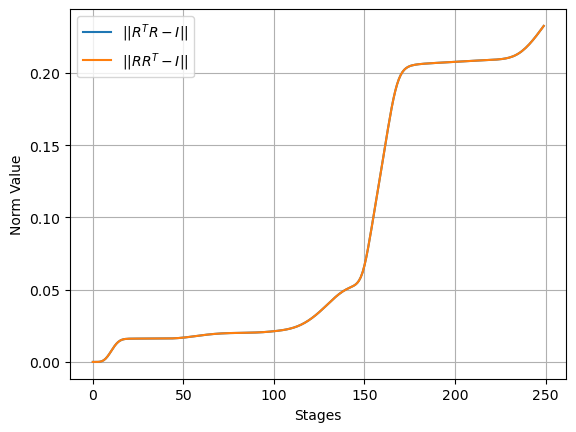

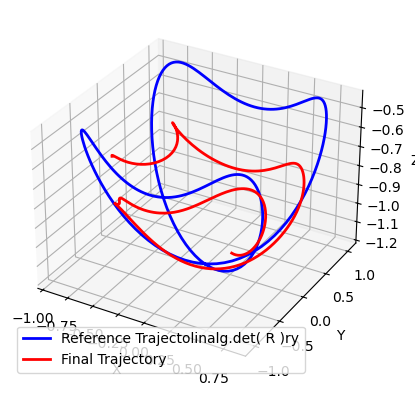

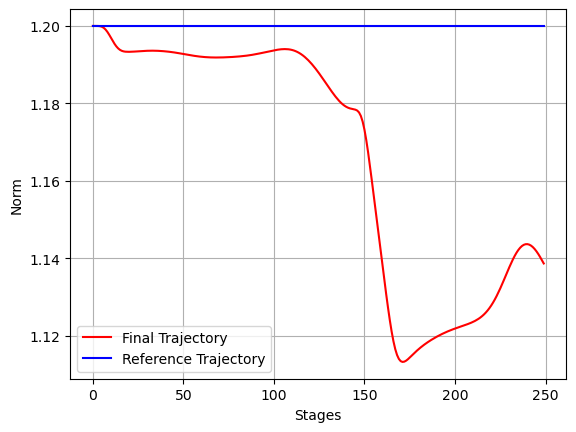

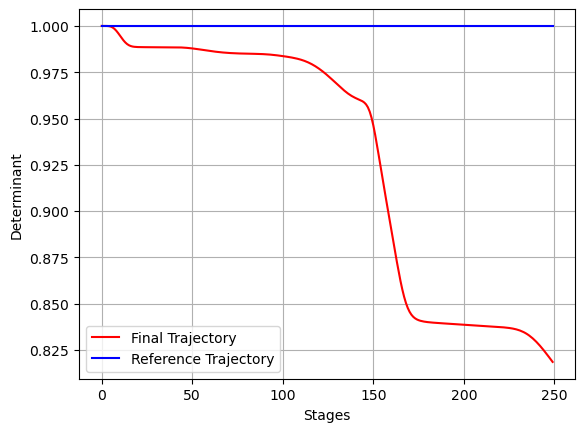

In [6]:
from scipy.linalg import norm
import matplotlib.pyplot as plt

print("horizon is ",len(R_sol))
list_RTR = [ R.T @ R - np.identity(3) for R in R_sol]
list_RRT = [ R @ R.T - np.identity(3) for R in R_sol]
list_RTR_norm = [ norm(R.T @ R - np.identity(3)) for R in R_sol]
list_RRT_norm = [ norm(R @ R.T - np.identity(3)) for R in R_sol]

plt.figure()
plt.plot(list_RTR_norm, label=r"$||R^T R - I||$")
plt.plot(list_RRT_norm, label=r"$||R R^T - I||$")
plt.grid()
plt.legend()
plt.xlabel('Stages')
plt.ylabel('Norm Value')

pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

rod_pos_sol = np.array([rotm @ updown_vector for rotm in R_sol]).reshape(Nsim+1, 3)
rod_pos_ref = np.array([rotm @ updown_vector for rotm in q_ref]).reshape(Nsim+1, 3)

norm_rod_pos_sol = np.array([norm(p) for p in rod_pos_sol ])
norm_rod_pos_ref = np.array([norm(p) for p in rod_pos_ref ])

det_sol = np.array([ np.linalg.det( rotm ) for rotm in R_sol])
det_ref = np.array([ np.linalg.det( rotm ) for rotm in q_ref])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(rod_pos_ref[:, 0], rod_pos_ref[:, 1], rod_pos_ref[:, 2],
            label='Reference Trajectolinalg.det( R )ry', color='blue', linewidth=2)
ax1.plot(rod_pos_sol[:, 0], rod_pos_sol[:, 1], rod_pos_sol[:, 2],
            label='Final Trajectory', color='red', linewidth=2)
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

fig2 = plt.figure()
plt.plot( norm_rod_pos_sol, label='Final Trajectory', color='red' )
plt.plot( norm_rod_pos_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Norm')
plt.legend()
plt.grid()

fig3 = plt.figure()
plt.plot( det_sol, label='Final Trajectory', color='red' )
plt.plot( det_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Determinant')
plt.legend()
plt.grid()






## Pendulum Baseline with Constraint Stabilization

In [24]:
import casadi as ca
import numpy as np
from scipy.spatial.transform import Rotation

# --------------------
# 1. 读取参考轨迹数据
# --------------------
path_to_reference_file = 'visualization/optimized_trajectories/path_3dpendulum_8shape.npy'
with open(path_to_reference_file, 'rb') as f:
    q_ref = np.load(f)   # 这里假设 q_ref[k] 对应 R_ref,k （某种形式储存）
    xi_ref = np.load(f)  # 这里假设 xi_ref[k] 对应 w_ref,k
    dt = np.load(f)

Nsim = q_ref.shape[0] - 1
# 初始状态 (姿态 + 角速度)
x0 = [q_ref[0], xi_ref[0]]  # 这里仅作演示，具体要看q_ref如何表示旋转


# --------------------
# 2. 定义指数映射和对数映射
# --------------------
def exp_so3(omega, h):
    """
    SO(3) 上的指数映射，使用 Rodrigues 公式进行离散化:
      R_{k+1} = R_k * exp( ω^∧ * h )
    这里 omega 为 R^3, h 为时间步长
    """
    theta = ca.sqrt(omega[0]**2 + omega[1]**2 + omega[2]**2)
    I3 = ca.DM.eye(3)
    skew_omega = ca.skew(omega)  # <-- 直接使用 casadi 内置 skew
    
    # 为了避免 theta=0 时数值不稳定，可以做一个 if_else 处理：
    sin_theta_over_theta = ca.if_else(
        theta < 1e-9,
        1 - theta**2/6.0,         # sin(t)/t ~ 1 - t^2/6 + ...
        ca.sin(theta)/theta
    )
    one_minus_cos_over_theta2 = ca.if_else(
        theta < 1e-9,
        0.5 - theta**2/24.0,      # (1-cos(t))/t^2 ~ 0.5 - t^2/24 + ...
        (1 - ca.cos(theta))/theta**2
    )
    
    # Rodrigues 公式: exp(a^∧) = I + sin(|a|)/|a| * a^∧ + (1-cos(|a|))/|a|^2 * (a^∧)^2
    A = I3 \
        + sin_theta_over_theta*skew_omega*h \
        + one_minus_cos_over_theta2*(skew_omega @ skew_omega)*(h*h)
    return A

def log_so3(R):
    """
    SO(3) 的对数映射 (用于计算姿态误差).
    """
    trace_R = R[0,0] + R[1,1] + R[2,2]
    cos_theta = 0.5*(trace_R - 1)
    # 裁剪 cos_theta 避免数值超限
    cos_theta_clamped = ca.fmax(ca.fmin(cos_theta, 1), -1)
    theta = ca.acos(cos_theta_clamped)

    # skew_part = [R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]^T / 2
    skew_part = ca.vertcat(
        (R[2,1] - R[1,2]),
        (R[0,2] - R[2,0]),
        (R[1,0] - R[0,1])
    )
    sin_theta = ca.sin(theta)
    
    # 如果 sin(theta)=0，则返回0向量（避免除0）
    factor = ca.if_else(
        ca.fabs(sin_theta) < 1e-9,
        0.5,  # 退化到零向量
        # theta/(2*sin_theta)
        theta/(2*sin_theta)
    )
    
    return factor * skew_part

# --------------------
# 3. 搭建 Opti 问题
# --------------------
opti = ca.Opti()

# 参数定义：模型参数 (例如转动惯量矩阵 J, 权重矩阵 Q, R等)
J = np.diag([0.5, 0.7, 0.9])            # 简单示例，假设球对称
J_inv = np.linalg.inv(J)
m = 1
length = 0.5
g = 9.8

Qx = np.diag([10., 10., 10.])           # 姿态误差的权重
Qw = np.diag([1.,  1.,  1.])           # 角速度误差的权重
QxN = 10 * Qx
QwN = 10 * Qw
R_ = np.identity(3) * 1e-2          # 控制输入惩罚

# 用于累计代价
cost = 0

# --------------------
# 4. 定义优化变量
# --------------------
R_vars = []
w_vars = []
u_vars = []

for k in range(Nsim+1):
    # R_k: 3x3 矩阵，有 9 个独立优化变量
    Rk = opti.variable(3,3)
    R_vars.append(Rk)
    # w_k: R^3
    wk = opti.variable(3,1)
    w_vars.append(wk)
    
    # 只在 k < Nsim 时定义控制变量 u_k
    if k < Nsim:
        uk = opti.variable(3,1)
        u_vars.append(uk)

# 设置初值 (从参考轨迹或者其他猜测中获取)
for k in range(Nsim+1):
    # 这里假设 q_ref[k] 是以 3x3 矩阵形式存储（如果不是，需要自己reshape）
    opti.set_initial(R_vars[k], q_ref[k])  
    opti.set_initial(w_vars[k], xi_ref[k])

for k in range(Nsim):
    opti.set_initial(u_vars[k], 0)

# --------------------
# 5. 动力学约束 + 正交约束 + 初始约束
# --------------------
for k in range(Nsim):
    Rk     = R_vars[k]
    Rk_next= R_vars[k+1]
    wk     = w_vars[k]
    wk_next= w_vars[k+1]
    uk     = u_vars[k]
    
    # (1) R_{k+1} = R_k * exp(w_k^∧ * h)
    kappa = 1e0
    Rk_prop = ca.mtimes(Rk, 
                        exp_so3(wk, dt) + kappa/2 * ( ca.inv(ca.mtimes(ca.transpose(Rk), Rk)) - ca.DM.eye(3)))
    opti.subject_to(Rk_next - Rk_prop == 0)

    # (2) w_{k+1} = w_k + dt * J^{-1}[J w_k x w_k + u_k]
    cross_term = ca.cross(J @ wk, wk)  # J*w_k 与 w_k 的叉乘
    
    down_vec = np.array([0., 0., -1.])
    rho = length / 2 * down_vec
    g_term = ca.cross( m*g*rho, ca.mtimes(ca.transpose(Rk), down_vec) )
    M = ca.cross( m*rho,  ca.mtimes(ca.transpose(Rk), uk) )

    wk_prop = wk + dt * (J_inv @ (cross_term + M))
    opti.subject_to(wk_next - wk_prop == 0)
    
    # (3) 正交约束 R_k^T * R_k = I
    # opti.subject_to(ca.mtimes(Rk.T, Rk) - ca.DM.eye(3) == 0)

# (4) 初始条件: 令 (R_0, w_0) = (q_ref[0], xi_ref[0])
q0 = ca.DM( Rotation.from_euler("y",50., degrees=True).as_matrix() )
xi0 = ca.DM( np.array([0.1,0.1,0.1]) )
opti.subject_to(R_vars[0] - q0 == 0)
opti.subject_to(w_vars[0] - xi0 == 0)
# opti.subject_to(R_vars[0] - ca.DM.eye(3) == 0)
# opti.subject_to(w_vars[0] == 0)


# 对终端 R_N 也加正交约束 (可选)
# opti.subject_to(ca.mtimes(R_vars[Nsim].T, R_vars[Nsim]) - ca.DM.eye(3) == 0)

# --------------------
# 6. 构建目标函数
# --------------------
for k in range(Nsim):
    Rk = R_vars[k]
    wk = w_vars[k]
    uk = u_vars[k]
    
    # 参考值
    Rref = q_ref[k]
    wref = xi_ref[k]
    Rref_dm = ca.DM(Rref)
    wref_dm = ca.DM(wref)

    # 姿态误差项：Log( R_k R_ref,k^{-1} )
    R_err = ca.mtimes(Rk, Rref_dm.T)  # 因为对正交矩阵 R_ref, R_ref^{-1} = R_ref^T
    log_Rerr = log_so3(R_err)
    cost_att = log_Rerr.T @ Qx @ log_Rerr
    
    # 角速度误差项
    w_diff = wk - wref_dm
    cost_w = w_diff.T @ Qw @ w_diff
    
    # 控制惩罚
    cost_u = uk.T @ R_ @ uk
    
    cost = cost + cost_att + cost_w + cost_u

# 终端项 l_N
R_N = R_vars[Nsim]
w_N = w_vars[Nsim]
RrefN = q_ref[Nsim]
wrefN = xi_ref[Nsim]
RrefN_dm = ca.DM(RrefN)
wrefN_dm = ca.DM(wrefN)

R_errN = ca.mtimes(R_N, RrefN_dm.T)
log_RerrN = log_so3(R_errN)
cost_attN = log_RerrN.T @ QxN @ log_RerrN

w_diffN = w_N - wrefN_dm
cost_wN = w_diffN.T @ QwN @ w_diffN

cost_terminal = cost_attN + cost_wN
cost = cost + cost_terminal

# 设置目标函数
opti.minimize(cost)

# --------------------
# 7. 求解
# --------------------
p_opts = {"verbose": False}
s_opts = {"max_iter": 2000}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError as e:
    print("Solver failed:", e)
    sol = None

# --------------------
# 8. 取回解并解析
# --------------------
if sol is not None:
    R_sol = []
    w_sol = []
    u_sol = []
    for k in range(Nsim+1):
        R_sol_k = sol.value(R_vars[k])
        w_sol_k = sol.value(w_vars[k])
        R_sol.append(R_sol_k)
        w_sol.append(w_sol_k)
        if k < Nsim:
            u_sol_k = sol.value(u_vars[k])
            u_sol.append(u_sol_k)
    
    print("Optimal cost:", sol.value(cost))
    # R_sol[k], w_sol[k], u_sol[k] 分别即为 k 时刻的最优解


This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    82347
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    46458

Total number of variables............................:     7497
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.22e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

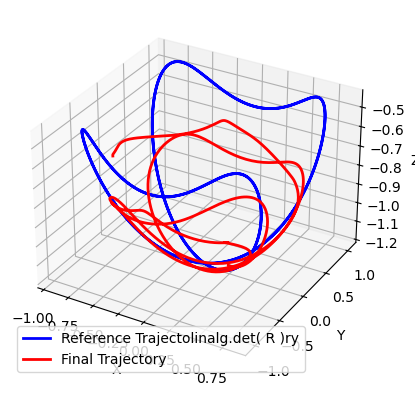

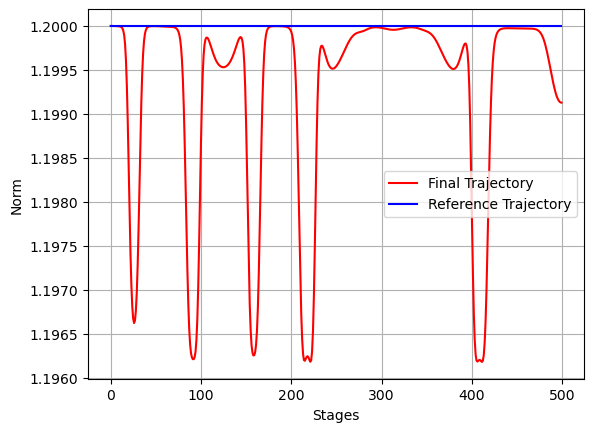

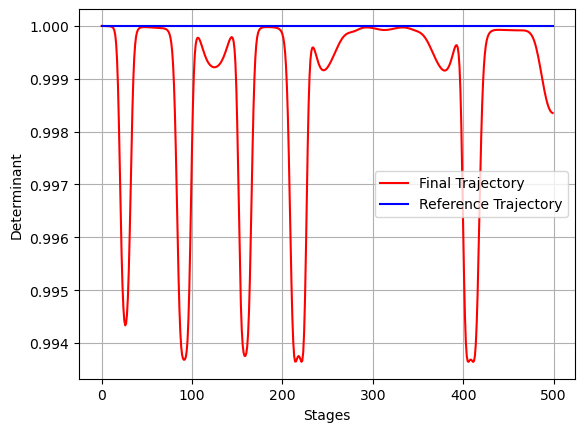

In [25]:
pendulum_length = 1.2
updown_vector = np.array([0., 0., -pendulum_length]).reshape(3,1)

rod_pos_sol = np.array([rotm @ updown_vector for rotm in R_sol]).reshape(Nsim+1, 3)
rod_pos_ref = np.array([rotm @ updown_vector for rotm in q_ref]).reshape(Nsim+1, 3)

norm_rod_pos_sol = np.array([norm(p) for p in rod_pos_sol ])
norm_rod_pos_ref = np.array([norm(p) for p in rod_pos_ref ])

det_sol = np.array([ np.linalg.det( rotm ) for rotm in R_sol])
det_ref = np.array([ np.linalg.det( rotm ) for rotm in q_ref])

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(rod_pos_ref[:, 0], rod_pos_ref[:, 1], rod_pos_ref[:, 2],
            label='Reference Trajectolinalg.det( R )ry', color='blue', linewidth=2)
ax1.plot(rod_pos_sol[:, 0], rod_pos_sol[:, 1], rod_pos_sol[:, 2],
            label='Final Trajectory', color='red', linewidth=2)
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

fig2 = plt.figure()
plt.plot( norm_rod_pos_sol, label='Final Trajectory', color='red' )
plt.plot( norm_rod_pos_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Norm')
plt.legend()
plt.grid()

fig3 = plt.figure()
plt.plot( det_sol, label='Final Trajectory', color='red' )
plt.plot( det_ref, label='Reference Trajectory', color='blue' )
plt.xlabel('Stages')
plt.ylabel('Determinant')
plt.legend()
plt.grid()




